# Build Image

In this notebook, we show the following steps for deploying a web service using AML:

- Create an image
- Test image locally


In [1]:
%matplotlib inline

import docker
import matplotlib.pyplot as plt
import numpy as np
import requests
from azureml.core import Workspace
from azure.mgmt.containerregistry import ContainerRegistryManagementClient
from azureml._model_management._util import (get_docker_client, pull_docker_image)
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.image import ContainerImage
from dotenv import set_key, get_key, find_dotenv
from utilities import load_image_into_numpy_array
from PIL import Image

import sys
import os
import json
sys.path.append("../models/research/")
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from matplotlib import pyplot as plt

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [3]:
image_name = 'maskrcnnoutofstockimage' # You can pick another image name here
model_name = get_key(env_path,"model_name")
resource_group = get_key(env_path, 'resource_group')

In [4]:
set_key(env_path, "image_name", image_name)

(True, 'image_name', 'maskrcnnoutofstockimage')

## Get workspace
Load existing workspace from the config file info.

In [5]:
ws = Workspace.from_config()
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /datadrive/OutOfStockDemo/.azureml/config.json


## Create Image

In [6]:
# create yml file to be used in the image
conda_pack = ["tensorflow==1.12.0"]
requirements = ["Pillow==6.0.0", "azureml-defaults==1.0.23"]

imgenv = CondaDependencies.create(conda_packages=conda_pack,pip_packages=requirements)
with open("img_env.yml", "w") as f:
    f.write(imgenv.serialize_to_string())

In [7]:
image_config = ContainerImage.image_configuration(execution_script = "detect.py",
                                                  runtime = "python",
                                                  conda_file = "img_env.yml",
                                                  description = "MaskRCNN image for out of stock model",
                                                  tags = {"data":"products","method":"tensorflow"}
                                               )

In [8]:
# create image. It may take upto 15-20 minutes. 
image = ContainerImage.create(name = image_name,
                              # this is the model object
                              models = [ws.models[model_name]],                              
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running....................................................................
SucceededImage creation operation finished for image maskrcnnoutofstockimage:3, operation "Succeeded"


In [10]:
# You can find the logs of image creation
# image.image_build_log_uri

# You can get the image object when not creating a new image
# image = ws.images[image_name]

## Test image locally
- Pull the image from ACR registry to local host 
- Start a container
- Test API call

In [9]:
# Getting your container details
container_reg = ws.get_details()["containerRegistry"]
reg_name=container_reg.split("/")[-1]
container_url = "\"" + image.image_location + "\","
subscription_id = ws.subscription_id

client = ContainerRegistryManagementClient(ws._auth,subscription_id)
result= client.registries.list_credentials(resource_group, reg_name, custom_headers=None, raw=False)
username = result.username
password = result.passwords[0].value
print('ContainerURL:{}'.format(image.image_location))
print('Servername: {}'.format(reg_name))
print('Username: {}'.format(username))
print('Password: {}'.format(password))

ContainerURL:fboyluamlsdkws7798851753.azurecr.io/maskrcnnoutofstockimage:3
Servername: fboyluamlsdkws7798851753
Username: fboyluamlsdkws7798851753
Password: Aorh+fqjzGK5Y0zO3pzf5IDd6iyAxcBe


In [10]:
dc = get_docker_client()

In [11]:
pull_docker_image(dc, image.image_location, username, password)

Pulling image from ACR (this may take a few minutes depending on image size)...

{"status":"Pulling from maskrcnnoutofstockimage","id":"3"}
{"status":"Already exists","progressDetail":{},"id":"34667c7e4631"}
{"status":"Already exists","progressDetail":{},"id":"d18d76a881a4"}
{"status":"Already exists","progressDetail":{},"id":"119c7358fbfc"}
{"status":"Already exists","progressDetail":{},"id":"2aaf13f3eff0"}
{"status":"Already exists","progressDetail":{},"id":"1bdde25ddf58"}
{"status":"Already exists","progressDetail":{},"id":"ef2db1f71795"}
{"status":"Already exists","progressDetail":{},"id":"0bdd4f1bb0ad"}
{"status":"Already exists","progressDetail":{},"id":"bd155d29affe"}
{"status":"Already exists","progressDetail":{},"id":"ac41bfedd89e"}
{"status":"Already exists","progressDetail":{},"id":"e249bf1582b1"}
{"status":"Already exists","progressDetail":{},"id":"84d596aff1a4"}
{"status":"Already exists","progressDetail":{},"id":"37a8cf32b32f"}
{"status":"Already exists","progressDetail":

{"status":"Extracting","progressDetail":{"current":12288000,"total":47976325},"progress":"[============\u003e                                      ]  12.29MB/47.98MB","id":"d4083e2dbb35"}
{"status":"Downloading","progressDetail":{"current":179310,"total":17008876},"progress":"[\u003e                                                  ]  179.3kB/17.01MB","id":"0b4d90ec5d15"}
{"status":"Downloading","progressDetail":{"current":4308992,"total":436473151},"progress":"[\u003e                                                  ]  4.309MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":16220160,"total":47976325},"progress":"[================\u003e                                  ]  16.22MB/47.98MB","id":"d4083e2dbb35"}
{"status":"Downloading","progressDetail":{"current":539758,"total":17008876},"progress":"[=\u003e                                                 ]  539.8kB/17.01MB","id":"0b4d90ec5d15"}
{"status":"Downloading","progressDetail":{"current":9175040,"

{"status":"Downloading","progressDetail":{"current":96763904,"total":436473151},"progress":"[===========\u003e                                       ]  96.76MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":104333312,"total":436473151},"progress":"[===========\u003e                                       ]  104.3MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":109199360,"total":436473151},"progress":"[============\u003e                                      ]  109.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":116228096,"total":436473151},"progress":"[=============\u003e                                     ]  116.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":122175488,"total":436473151},"progress":"[=============\u003e                                     ]  122.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"cur

{"status":"Downloading","progressDetail":{"current":294649856,"total":436473151},"progress":"[=================================\u003e                 ]  294.6MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":297893888,"total":436473151},"progress":"[==================================\u003e                ]  297.9MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":302219264,"total":436473151},"progress":"[==================================\u003e                ]  302.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":306544640,"total":436473151},"progress":"[===================================\u003e               ]  306.5MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"current":310870016,"total":436473151},"progress":"[===================================\u003e               ]  310.9MB/436.5MB","id":"671b506ac20d"}
{"status":"Downloading","progressDetail":{"cu

{"status":"Extracting","progressDetail":{"current":21168128,"total":436473151},"progress":"[==\u003e                                                ]  21.17MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":23953408,"total":436473151},"progress":"[==\u003e                                                ]  23.95MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":26738688,"total":436473151},"progress":"[===\u003e                                               ]  26.74MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":29523968,"total":436473151},"progress":"[===\u003e                                               ]  29.52MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":32309248,"total":436473151},"progress":"[===\u003e                                               ]  32.31MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":3509

{"status":"Extracting","progressDetail":{"current":138706944,"total":436473151},"progress":"[===============\u003e                                   ]  138.7MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":140935168,"total":436473151},"progress":"[================\u003e                                  ]  140.9MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":143720448,"total":436473151},"progress":"[================\u003e                                  ]  143.7MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":146505728,"total":436473151},"progress":"[================\u003e                                  ]  146.5MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":149291008,"total":436473151},"progress":"[=================\u003e                                 ]  149.3MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current"

{"status":"Extracting","progressDetail":{"current":259031040,"total":436473151},"progress":"[=============================\u003e                     ]    259MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":261816320,"total":436473151},"progress":"[=============================\u003e                     ]  261.8MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":264601600,"total":436473151},"progress":"[==============================\u003e                    ]  264.6MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":267386880,"total":436473151},"progress":"[==============================\u003e                    ]  267.4MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":270172160,"total":436473151},"progress":"[==============================\u003e                    ]  270.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current"

{"status":"Extracting","progressDetail":{"current":366542848,"total":436473151},"progress":"[=========================================\u003e         ]  366.5MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":368771072,"total":436473151},"progress":"[==========================================\u003e        ]  368.8MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":370999296,"total":436473151},"progress":"[==========================================\u003e        ]    371MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":373227520,"total":436473151},"progress":"[==========================================\u003e        ]  373.2MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current":375455744,"total":436473151},"progress":"[===========================================\u003e       ]  375.5MB/436.5MB","id":"671b506ac20d"}
{"status":"Extracting","progressDetail":{"current"

{"status":"Extracting","progressDetail":{"current":15532032,"total":17008876},"progress":"[=============================================\u003e     ]  15.53MB/17.01MB","id":"0b4d90ec5d15"}
{"status":"Extracting","progressDetail":{"current":17008876,"total":17008876},"progress":"[==================================================\u003e]  17.01MB/17.01MB","id":"0b4d90ec5d15"}
{"status":"Pull complete","progressDetail":{},"id":"0b4d90ec5d15"}
{"status":"Digest: sha256:5227381bc734cb9912b1ca7ef806e4e88c1fdf9f56b517c9065c7d4345d17506"}
{"status":"Status: Downloaded newer image for fboyluamlsdkws7798851753.azurecr.io/maskrcnnoutofstockimage:3"}


In [12]:
# make sure port 80 is not occupied
container_labels = {'containerName': 'tfgpu'}
container = dc.containers.run(image.image_location, 
                                         detach=True, 
                                         ports={'5001/tcp': 80},
                                         labels=container_labels,
                                         runtime='nvidia' )

In [33]:
for log_msg in container.logs(stream=True):
    str_msg = log_msg.decode('UTF8')
    print(str_msg)

2019-05-02T14:08:43,623258933+00:00 - gunicorn/run 

2019-05-02T14:08:43,623285333+00:00 - iot-server/run 

2019-05-02T14:08:43,623409332+00:00 - rsyslog/run 

2019-05-02T14:08:43,623909730+00:00 - nginx/run 

EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...

2019-05-02T14:08:43,689246773+00:00 - iot-server/finish 1 0

2019-05-02T14:08:43,690234067+00:00 - Exit code 1 is normal. Not restarting iot-server.

Starting gunicorn 19.6.0

Listening at: http://127.0.0.1:9090 (16)

Using worker: sync

worker timeout is set to 300

Booting worker with pid: 57

Initializing logger

Starting up app insights client

Starting up request id generator

Starting up app insight hooks

Invoking user's init function

2019-05-02 14:08:48,279 | azureml.core.run | DEBUG | Could not load run context Could not load a submitted run, if outside of an execution context, use experiment.start_logging to initialize an azureml.core.Run., switching offline: False

2019-05-02 14:08:48,279 | az

KeyboardInterrupt: 

In [14]:
client = docker.APIClient()
details = client.inspect_container(container.id)

In [15]:
service_ip = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostIp']
service_port = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostPort']

Wait a few seconds for the application to spin up and then check that everything works.

In [16]:
print('Checking service on {} port {}'.format(service_ip, service_port))

Checking service on 0.0.0.0 port 80


In [17]:
endpoint="http://__service_ip:__service_port"
endpoint = endpoint.replace('__service_ip', service_ip)
endpoint = endpoint.replace('__service_port', service_port)

In [38]:
!curl 'http://{service_ip}:{service_port}/'

Healthy

In [48]:
img_data = open('./annotated/runeightft3/1555539843.1911.jpg', "rb")
%time r = requests.post('http://0.0.0.0:80/score', files={'image': img_data})

CPU times: user 3.41 ms, sys: 489 µs, total: 3.9 ms
Wall time: 791 ms


In [49]:
print(r)
r.json()

<Response [200]>


'{"num_detections": 19, "detection_boxes": [[0.330192893743515, 0.5970863103866577, 0.5279752612113953, 0.6818046569824219], [0.34462764859199524, 0.30942708253860474, 0.5342136025428772, 0.4091068506240845], [0.5579608678817749, 0.6659886240959167, 0.7058756947517395, 0.7356888651847839], [0.8462153673171997, 0.5819202065467834, 0.9259055852890015, 0.6555759906768799], [0.05082394555211067, 0.5115424394607544, 0.29503607749938965, 0.6307106614112854], [0.5608945488929749, 0.5581010580062866, 0.6987683773040771, 0.6162829995155334], [0.7228192090988159, 0.5086413621902466, 0.8264477252960205, 0.5722082853317261], [0.3870369493961334, 0.15404139459133148, 0.5609389543533325, 0.22415830194950104], [0.7292642593383789, 0.696726381778717, 0.8231830596923828, 0.7445048093795776], [0.5592306852340698, 0.41125041246414185, 0.6983488202095032, 0.4602470099925995], [0.8506065011024475, 0.40294259786605835, 0.9280971884727478, 0.44249510765075684], [0.7315962314605713, 0.31460776925086975, 0.826

In [50]:
PATH_TO_LABELS = 'stockout_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

IMAGE_SIZE = (24, 18)

In [51]:
img = Image.open(img_data)
image_np = load_image_into_numpy_array(img)
output_dict = json.loads(r.json())

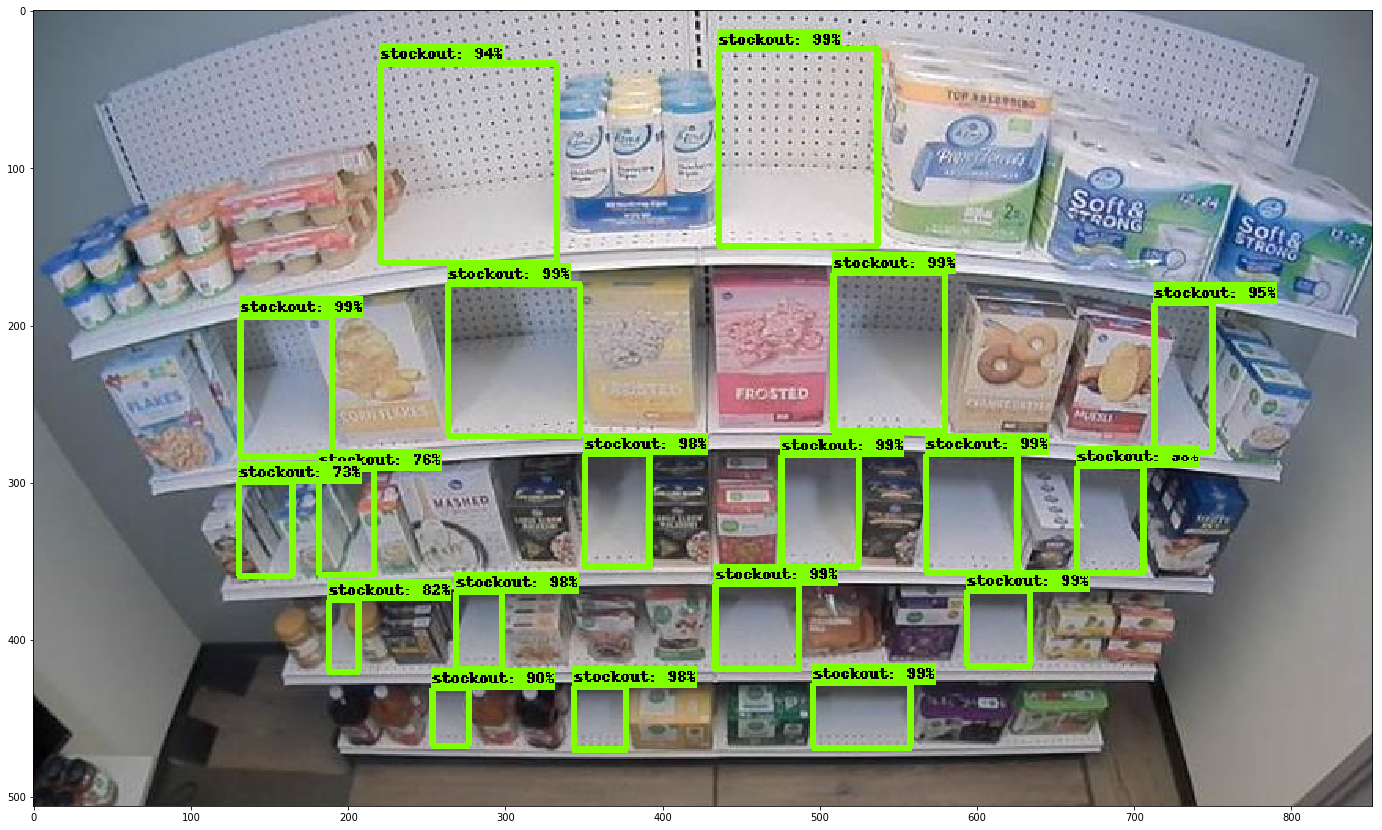

In [52]:
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  np.array(output_dict['detection_boxes']),
  np.array(output_dict['detection_classes']),
  np.array(output_dict['detection_scores']),
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=4)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [53]:
container.stop()

In [54]:
# remove stopped container
!docker system prune -f

Deleted Containers:
eb1e1cbca0434a0a35fad51ae0a99c3f0a61af1dc7f993273b4e051c5bc359f0

Total reclaimed space: 24.73MB
